In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import importlib.util
spec = importlib.util.spec_from_file_location("models", "/home/pbromley/mnist_test/models.py")
models = importlib.util.module_from_spec(spec)
spec.loader.exec_module(models)
from sklearn.manifold import TSNE
import umap
import seaborn as sns
import matplotlib as mpl

In [2]:
# Load pytorch modules
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.autograd as autograd
import torch.nn.functional as F

In [5]:
import gen_models
# import gan_trainer
import data_helper
import importlib
import utils
import classifiers

In [4]:
from Bio.Seq import Seq
from Bio.Alphabet import single_letter_alphabet
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO

In [6]:
real_one_hot, components, _, _ = data_helper.load_the_data('strong')
real_one_hot_all, _, _, _ = data_helper.load_the_data('mean_signal')
real_seqs = [utils.one_hot_to_seq(o) for o in real_one_hot]

In [7]:
nz = 100

G = gen_models.snp_generator_2d_temp_2a(50, 320, 11)
G.load_state_dict(torch.load("/home/pbromley/generative_dhs/saved_models/no-condition-ms-g.pth"))
G.train(False)
G.to("cuda")

one_hot_seqs = np.zeros((64000, 1, 100, 4))
for i in range(500):
    noise = torch.from_numpy(np.random.normal(0, 1, (128, 50))).float().cuda()
    with torch.no_grad():
        one_hot_seqs[i*128:(i+1)*128] = G(noise).detach().cpu().numpy()

one_hot_seqs = one_hot_seqs.reshape(-1, 100, 4)

print("Converting one-hot to normal...")
seqs = [utils.one_hot_to_seq(one_hot_seq) for one_hot_seq in one_hot_seqs]

Converting one-hot to normal...


In [8]:
model = classifiers.tmp(0.2) #TODO which framework to load/how to specify?
model.load_state_dict(torch.load("/home/pbromley/generative_dhs/saved_models/classifiers/aug.pth"))
model.train(False)
model.to("cuda")
m1 = list(model.children())[0]
m2 = list(model.children())[-1][:-1]

G.eval()
model.eval()
m1.eval()
m2.eval()

Sequential(
  (0): Linear(in_features=512, out_features=100, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.2)
  (3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Linear(in_features=100, out_features=16, bias=True)
)

In [16]:
opt_z_arr = torch.zeros(100, 50).normal_(0, 1)
one_hots_before = G(opt_z_arr.cuda()).detach().cpu().numpy().squeeze()
one_hots = np.zeros((100, 100, 4))
for i in range(len(opt_z_arr)):
    opt_z = opt_z_arr[i].cuda().requires_grad_()
    optimizer = optim.Adam([opt_z], lr=0.017, betas=(0.9, 0.79))
    h = opt_z.register_hook(lambda grad: grad + torch.zeros_like(grad).normal_(0, 1e-4))
    print("Seq " + str(i))
    for j in range(4000):
        G.zero_grad()
        m1.zero_grad()
        m2.zero_grad()
        optimizer.zero_grad()
        seq = G(opt_z).transpose(2, 3).view(1, 4, 100)
        tmp = m1(seq).view(-1, 512)
        pred = m2(tmp).squeeze()
        loss = (pred[4] + pred[14]) + (0.3 * torch.abs(pred[4]-pred[14]))
        loss.backward()
        optimizer.step()
        
        if j % 2000 == 0:
#             print(pred)
            print("  " + str(pred[4].item()) + "\t" + str(pred[14].item()))
    
    one_hots[i] = seq.detach().cpu().numpy().transpose(0, 2, 1)

Seq 0
  -13.539947509765625	-4.890126705169678
  -89.11307525634766	-143.11724853515625
Seq 1
  -13.61730670928955	-7.996859073638916
  -96.33757781982422	-73.79309844970703
Seq 2
  22.48065948486328	18.56913948059082
  -100.45453643798828	-85.34288787841797
Seq 3
  0.9201138019561768	-1.5054817199707031
  -112.41574096679688	-113.81585693359375
Seq 4
  5.82375955581665	-4.909900188446045
  -32.221961975097656	-43.40289306640625
Seq 5
  -5.4875569343566895	-11.45833683013916
  -122.54670715332031	-104.62767028808594
Seq 6
  12.992758750915527	2.364713191986084
  -89.15048217773438	-93.11442565917969
Seq 7
  -14.94769287109375	-9.426504135131836
  -66.55583190917969	-59.14424133300781
Seq 8
  23.542634963989258	8.64477825164795
  -19.196935653686523	-18.768190383911133
Seq 9
  7.797459125518799	4.911478042602539
  -53.25725173950195	-75.47442626953125
Seq 10
  -7.076977252960205	-1.1387790441513062
  -70.87767791748047	-64.05563354492188
Seq 11
  -3.5648140907287598	-14.391411781311035


  -113.86151885986328	-93.84510803222656
Seq 95
  7.091001033782959	6.083431243896484
  -63.75543975830078	-93.71054077148438
Seq 96
  -26.97963523864746	-14.402398109436035
  -77.10189819335938	-67.76001739501953
Seq 97
  -3.377861738204956	-8.34784984588623
  -99.19495391845703	-98.9819564819336
Seq 98
  -4.0913472175598145	-9.53187370300293
  -59.36937713623047	-66.07415008544922
Seq 99
  -4.9264936447143555	7.4207940101623535
  -81.6529541015625	-69.26710510253906


In [17]:
#np.save("/home/pbromley/generative_dhs/notebooks/optimize_for_none.npy", one_hots)

In [18]:
# one_hots = np.load("/home/pbromley/generative_dhs/notebooks/optimize_for_none.npy")
scan_list, scan_list_real = [], []
for i in np.array([4, 14]):
    scan_list.append(utils.get_motif_scan(one_hots, i))
    scan_list_real.append(utils.get_motif_scan(one_hot_seqs, i))
    print(i)
    

4
14


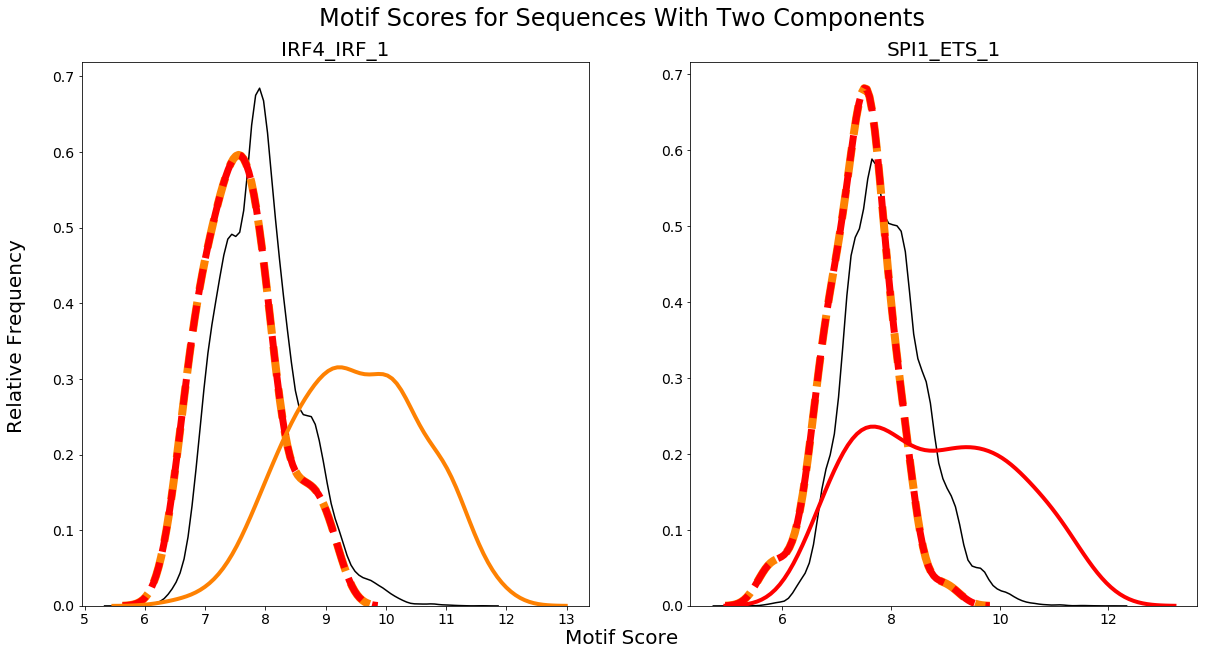

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
# plt.hist(m_scan_5, bins=30)

sns.distplot(scan_list_real[0], hist=False, ax=ax[0], color='black')
sns.distplot(scan_list[0], hist=False, ax=ax[0], color=utils.get_dhs_colors()[4].tolist(), kde_kws={'linestyle':'--', 'linewidth':8})
sns.distplot(scan_list[0], hist=False, ax=ax[0], color=utils.get_dhs_colors()[14].tolist(), kde_kws={'linestyle':'--', 'linewidth':7})
sns.distplot(opt_lymph, hist=False, ax=ax[0], color=utils.get_dhs_colors()[4].tolist(), kde_kws={'linewidth':4})
ax[0].set_title(utils.get_motifs()[1], fontsize=20)
ax[0].tick_params(labelsize=14)

sns.distplot(scan_list_real[1], hist=False, ax=ax[1], color='black')
sns.distplot(scan_list[1], hist=False, ax=ax[1], color=utils.get_dhs_colors()[4].tolist(), kde_kws={'linestyle':'--', 'linewidth':8})
sns.distplot(scan_list[1], hist=False, ax=ax[1], color=utils.get_dhs_colors()[14].tolist(), kde_kws={'linestyle':'--', 'linewidth':7})
sns.distplot(opt_hsc, hist=False, ax=ax[1], color=utils.get_dhs_colors()[14].tolist(), kde_kws={'linewidth':4})
ax[1].set_title(utils.get_motifs()[2], fontsize=20)
ax[1].tick_params(labelsize=14)
fig.text(0.5, 0.08, 'Motif Score', ha="center", va="center", fontsize=20)
fig.text(0.08, 0.5, "Relative Frequency", ha="center", va="center", rotation="vertical", fontsize=20)
fig.text(0.5, 0.94, 'Motif Scores for Sequences With Two Components', fontsize=24, ha="center", va="center")
plt.savefig("/home/pbromley/generative_dhs/figures/optimized/not_irf_and_spi.pdf", format='pdf', bbox_inches='tight')

In [12]:
seq_array_lymph = []
seq_array_hsc = []
for i in range(200):
    with open("track2/for-deltas-{0}-5.txt".format(i), "r") as f:
        seq_array_lymph.append(Seq(f.readlines()[-1][:-1]))
        
for i in range(200):
    with open("track2/for-deltas-{0}-15.txt".format(i), "r") as f:
        seq_array_hsc.append(Seq(f.readlines()[-1][:-1]))
        
lymph_oh = np.array([utils.seq_to_one_hot(s) for s in seq_array_lymph])
hsc_oh = np.array([utils.seq_to_one_hot(s) for s in seq_array_hsc])

In [13]:
opt_lymph = utils.get_motif_scan(x=lymph_oh, comp=4)
opt_hsc = utils.get_motif_scan(x=hsc_oh, comp=14)

In [14]:
my_seqs = [utils.one_hot_to_seq(o) for o in one_hots]
utils.calc_overall_composition(my_seqs)

array([ 20.13,  26.26,  23.75,  29.86])

In [13]:
my_seqs

[Seq('CCCCACTTCCTGTGTGGGTTCTGCTTCTGAAACTGCACTTCCTCTTTTTTGCCC...GGC', SingleLetterAlphabet()),
 Seq('GTGCGACCGCAGGCCTGCGCTCCTGCTTGCGGTTCCGGCTGCTCTCTGGCGGTC...ACT', SingleLetterAlphabet()),
 Seq('AATTTTGGTTTGCTTCTGTGGTCTTTTGTAAGTTTTCTGACCAGCCCTATCCAC...TCA', SingleLetterAlphabet()),
 Seq('ACCCTCCCTCAGCTTCCGCTTTCTGAAGGGGGTGGCACCTCCAGCCCCACCCAC...GGT', SingleLetterAlphabet()),
 Seq('AAGCCACCCCCTGCCTAGGGGAAGTGGTACCCACATTGTGGCCTGGGTGGTTTT...CCT', SingleLetterAlphabet()),
 Seq('ACTGTACCCACAATGTACTTGAAGACAGCATCTGCTGCAGCAGTGAGCGGTGTT...CAG', SingleLetterAlphabet()),
 Seq('GGGCGTGGTGCCGCACCCCGGGCGGGGGTGCCCCGGCCCAGCCTGGAGGGGGGT...CGC', SingleLetterAlphabet()),
 Seq('CCCCTAGCTCCAGTTCTGCGGTTTCTTCTCAGACCCATGCGCCCACTTCCCCAC...GCC', SingleLetterAlphabet()),
 Seq('GGGGTGGGCCCTCCATCCGGGAAACCCCCATCTGTGGTTATCTAAGATACTGAT...TCT', SingleLetterAlphabet()),
 Seq('TGCTGCCTGAGGCCACAGTGTGGGTGTGGGGTGTTTTTATCTTCCTGGGTGATA...AGG', SingleLetterAlphabet()),
 Seq('GTGGCAGGAGGGTGGGGTGGGGAAGAACCTTTCTTTTTGCTTGCAGGATGTGGG

### TSNE on Zs

In [43]:
comp = 7
comp_zs7 = np.load("/home/pbromley/generative_dhs/optimized/nz100/zs-{0}.npy".format(comp+1))
comp = 6
comp_zs6 = np.load("/home/pbromley/generative_dhs/optimized/nz100/zs-{0}.npy".format(comp+1))
comp = 5
comp_zs5 = np.load("/home/pbromley/generative_dhs/optimized/nz100/zs-{0}.npy".format(comp+1))
comp = 4
comp_zs4 = np.load("/home/pbromley/generative_dhs/optimized/nz100/zs-{0}.npy".format(comp+1))
comp = 3
comp_zs3 = np.load("/home/pbromley/generative_dhs/optimized/nz100/zs-{0}.npy".format(comp+1))
comp = 2
comp_zs2 = np.load("/home/pbromley/generative_dhs/optimized/nz100/zs-{0}.npy".format(comp+1))
comp = 1
comp_zs1 = np.load("/home/pbromley/generative_dhs/optimized/nz100/zs-{0}.npy".format(comp+1))
comp = 0
comp_zs0 = np.load("/home/pbromley/generative_dhs/optimized/nz100/zs-{0}.npy".format(comp+1))

In [44]:
all_zs = np.concatenate([comp_zs0, comp_zs1, comp_zs2, comp_zs3, comp_zs4, comp_zs5, comp_zs6, comp_zs7])

In [ ]:
tsne = TSNE(n_components=2, perplexity=50, learning_rate=500.0, n_iter=1000, verbose=2)

x_emb = tsne.fit_transform(all_zs)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.161s...


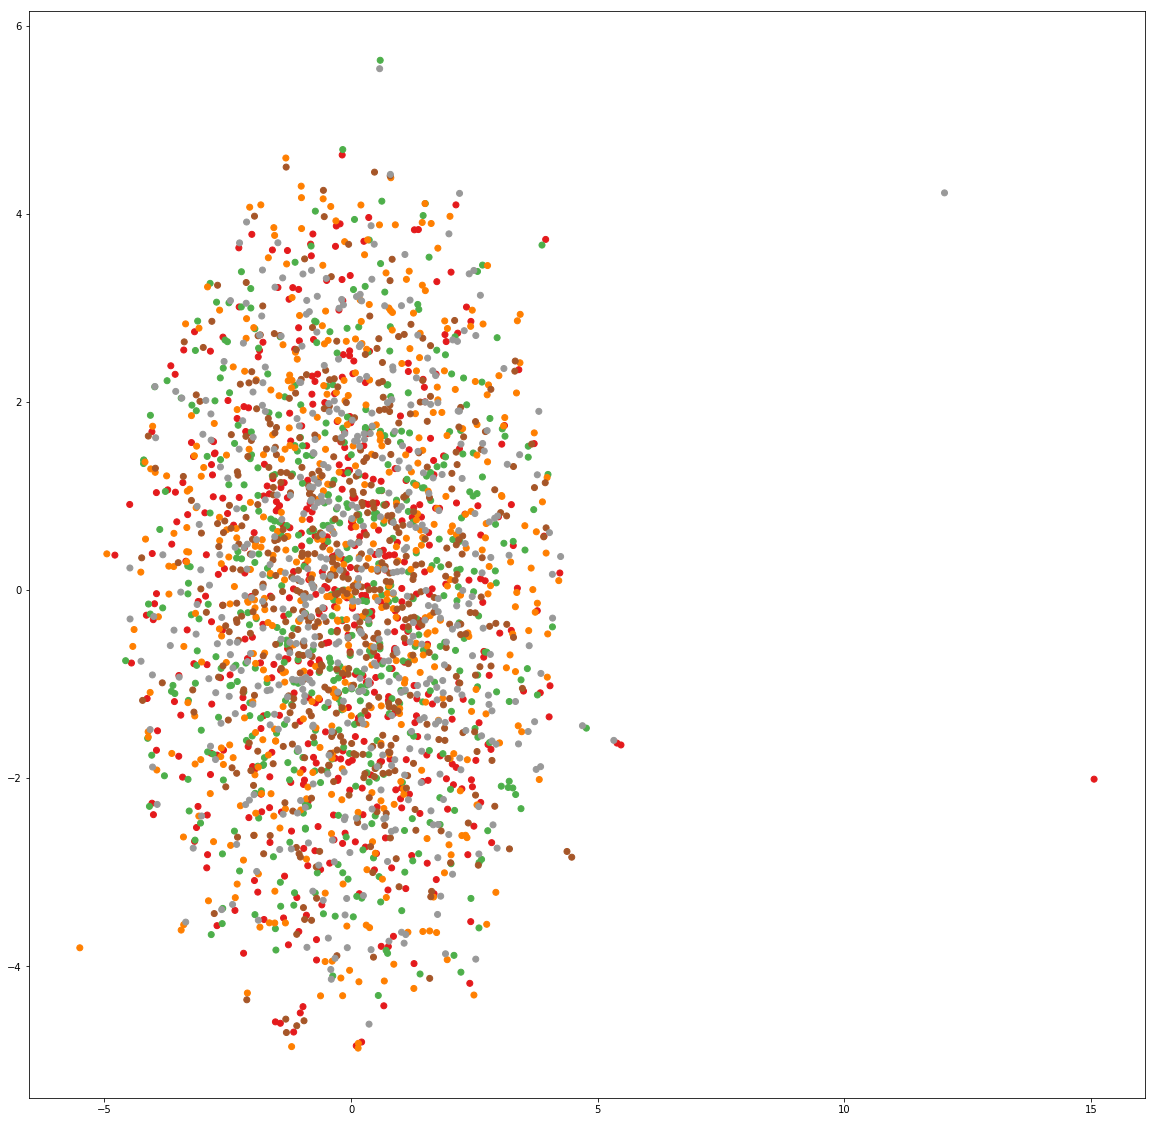

In [56]:
# import matplotlib as mpl
# cmap = mpl.colors.ListedColormap(utils.get_dhs_colors()/255)
plt.figure(figsize=(20, 20))
plt.scatter(x_emb[:, 0], x_emb[:, 1], c=np.repeat(np.arange(0, 5), 500), cmap="Set1")


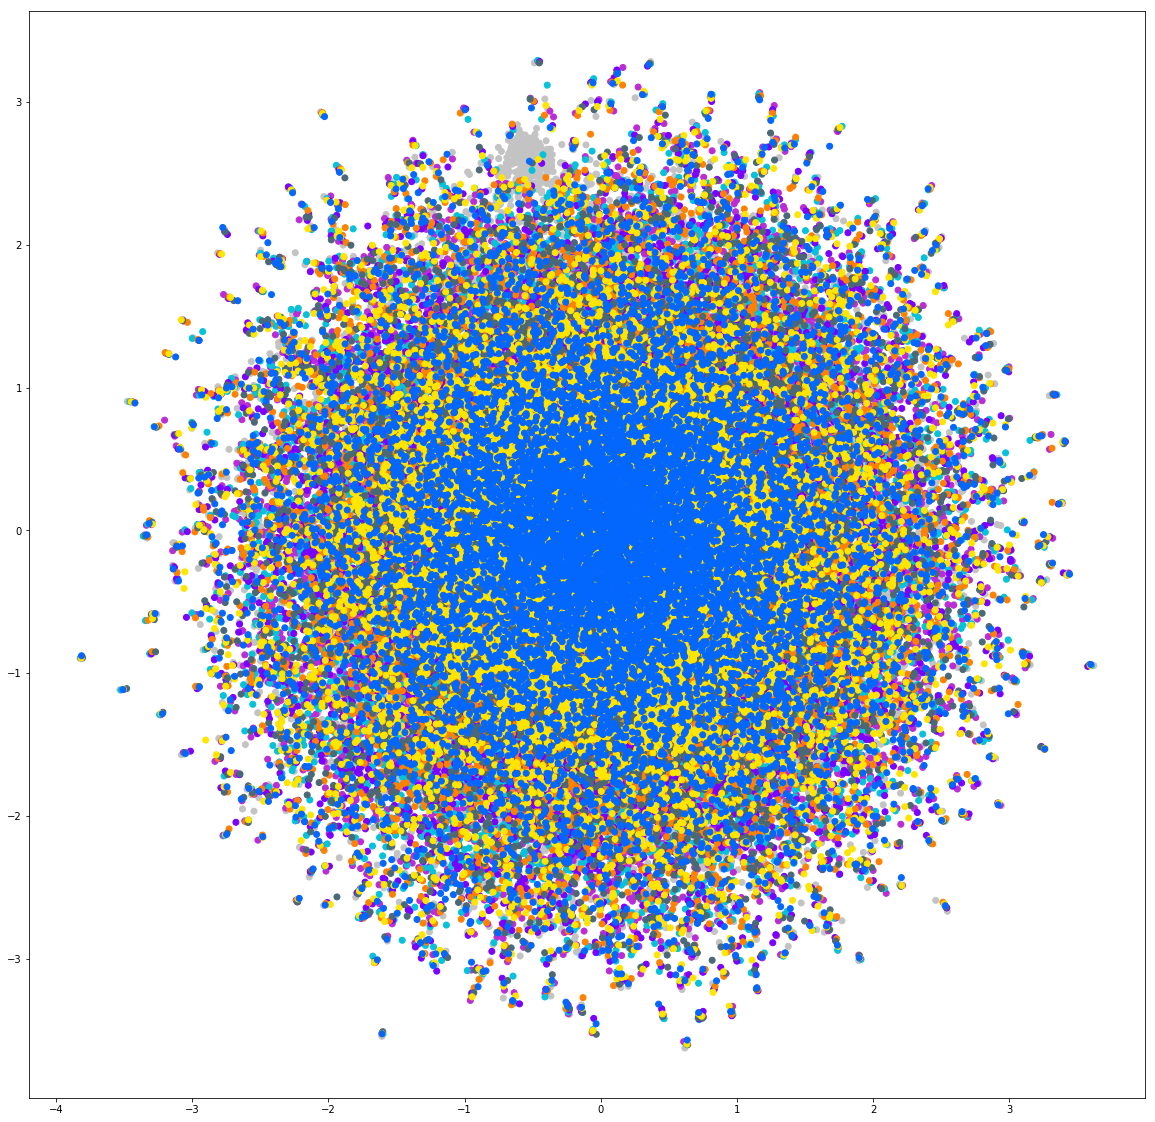

In [47]:
# reducer = umap.UMAP()
# embedding = reducer.fit_transform(all_zs)
cmap = mpl.colors.ListedColormap(utils.get_dhs_colors()[:8])
plt.figure(figsize=(20, 20))
plt.scatter(embedding[:, 0], embedding[:, 1], c=np.repeat(np.arange(0, 8), 10000), cmap=cmap)

In [55]:
pct_change = {}
start_zs = np.load("/home/pbromley/generative_dhs/data_numpy/fixed_zs_100.npy")
start_seqs = G(torch.from_numpy(start_zs[:5000]).float().cuda()).detach().cpu().numpy().squeeze()
for i in range(16):
    deltas = np.load("/home/pbromley/generative_dhs/optimized/nz100/deltas-{0}.npy".format(i+1))
    start_scan = utils.get_motif_scan(start_seqs[:len(deltas)], i)
    pct_change[i] = deltas/start_scan
    print(i)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


Text(0.5,0.95,'Change in Motif Scan Max During Optimization')

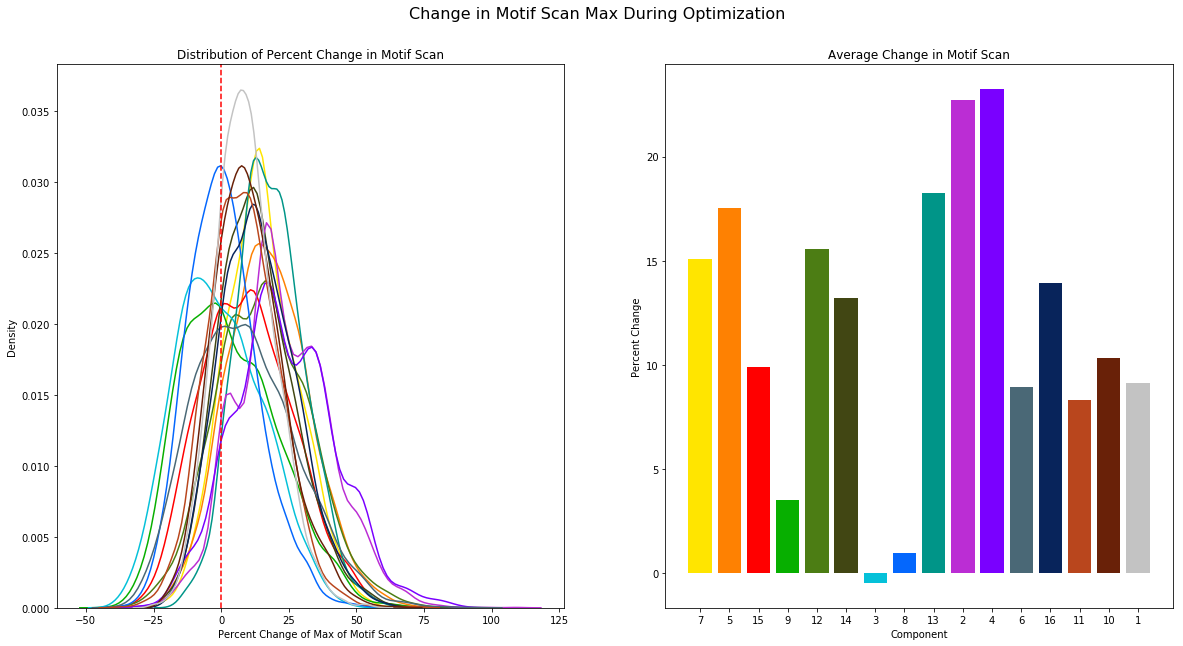

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
for i, order in enumerate(utils.get_order()):
#     deltas = np.load("/home/pbromley/generative_dhs/optimized/nz100/deltas-{0}.npy".format(order))
    p_change = pct_change[order-1]*100
    sns.distplot(p_change, hist=False, color=utils.get_dhs_colors()[order-1].tolist(), ax=ax[0])
    mean, conf_low, conf_high = mean_confidence_interval(p_change)
#     ax[1].bar([i], mean, yerr=[[conf_low], [conf_high]], capsize=3, color=utils.get_dhs_colors()[order-1])
    ax[1].bar([i], mean, color=utils.get_dhs_colors()[order-1])
ax[0].axvline(x=0, c='red', linestyle='--')
ax[0].set_title("Distribution of Percent Change in Motif Scan")
ax[0].set_xlabel("Percent Change of Max of Motif Scan")
ax[0].set_ylabel("Density")
ax[1].set_xticks(np.arange(0, 16))
ax[1].set_xticklabels(utils.get_order())
ax[1].set_title("Average Change in Motif Scan")
ax[1].set_xlabel("Component")
ax[1].set_ylabel("Percent Change")
# plt.xlim(-6.5, 6.5)
fig.text(0.5, 0.95, "Change in Motif Scan Max During Optimization", fontsize=16, ha="center", va="center")

In [79]:
import scipy.stats
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [81]:
mat = np.zeros((10000, 16))
for i, order in enumerate(utils.get_order()):
    if order >= 16:
        continue
    ds = np.load("/home/pbromley/generative_dhs/optimized/nz100/deltas-{0}.npy".format(order))
    mat[:, i] = ds
    

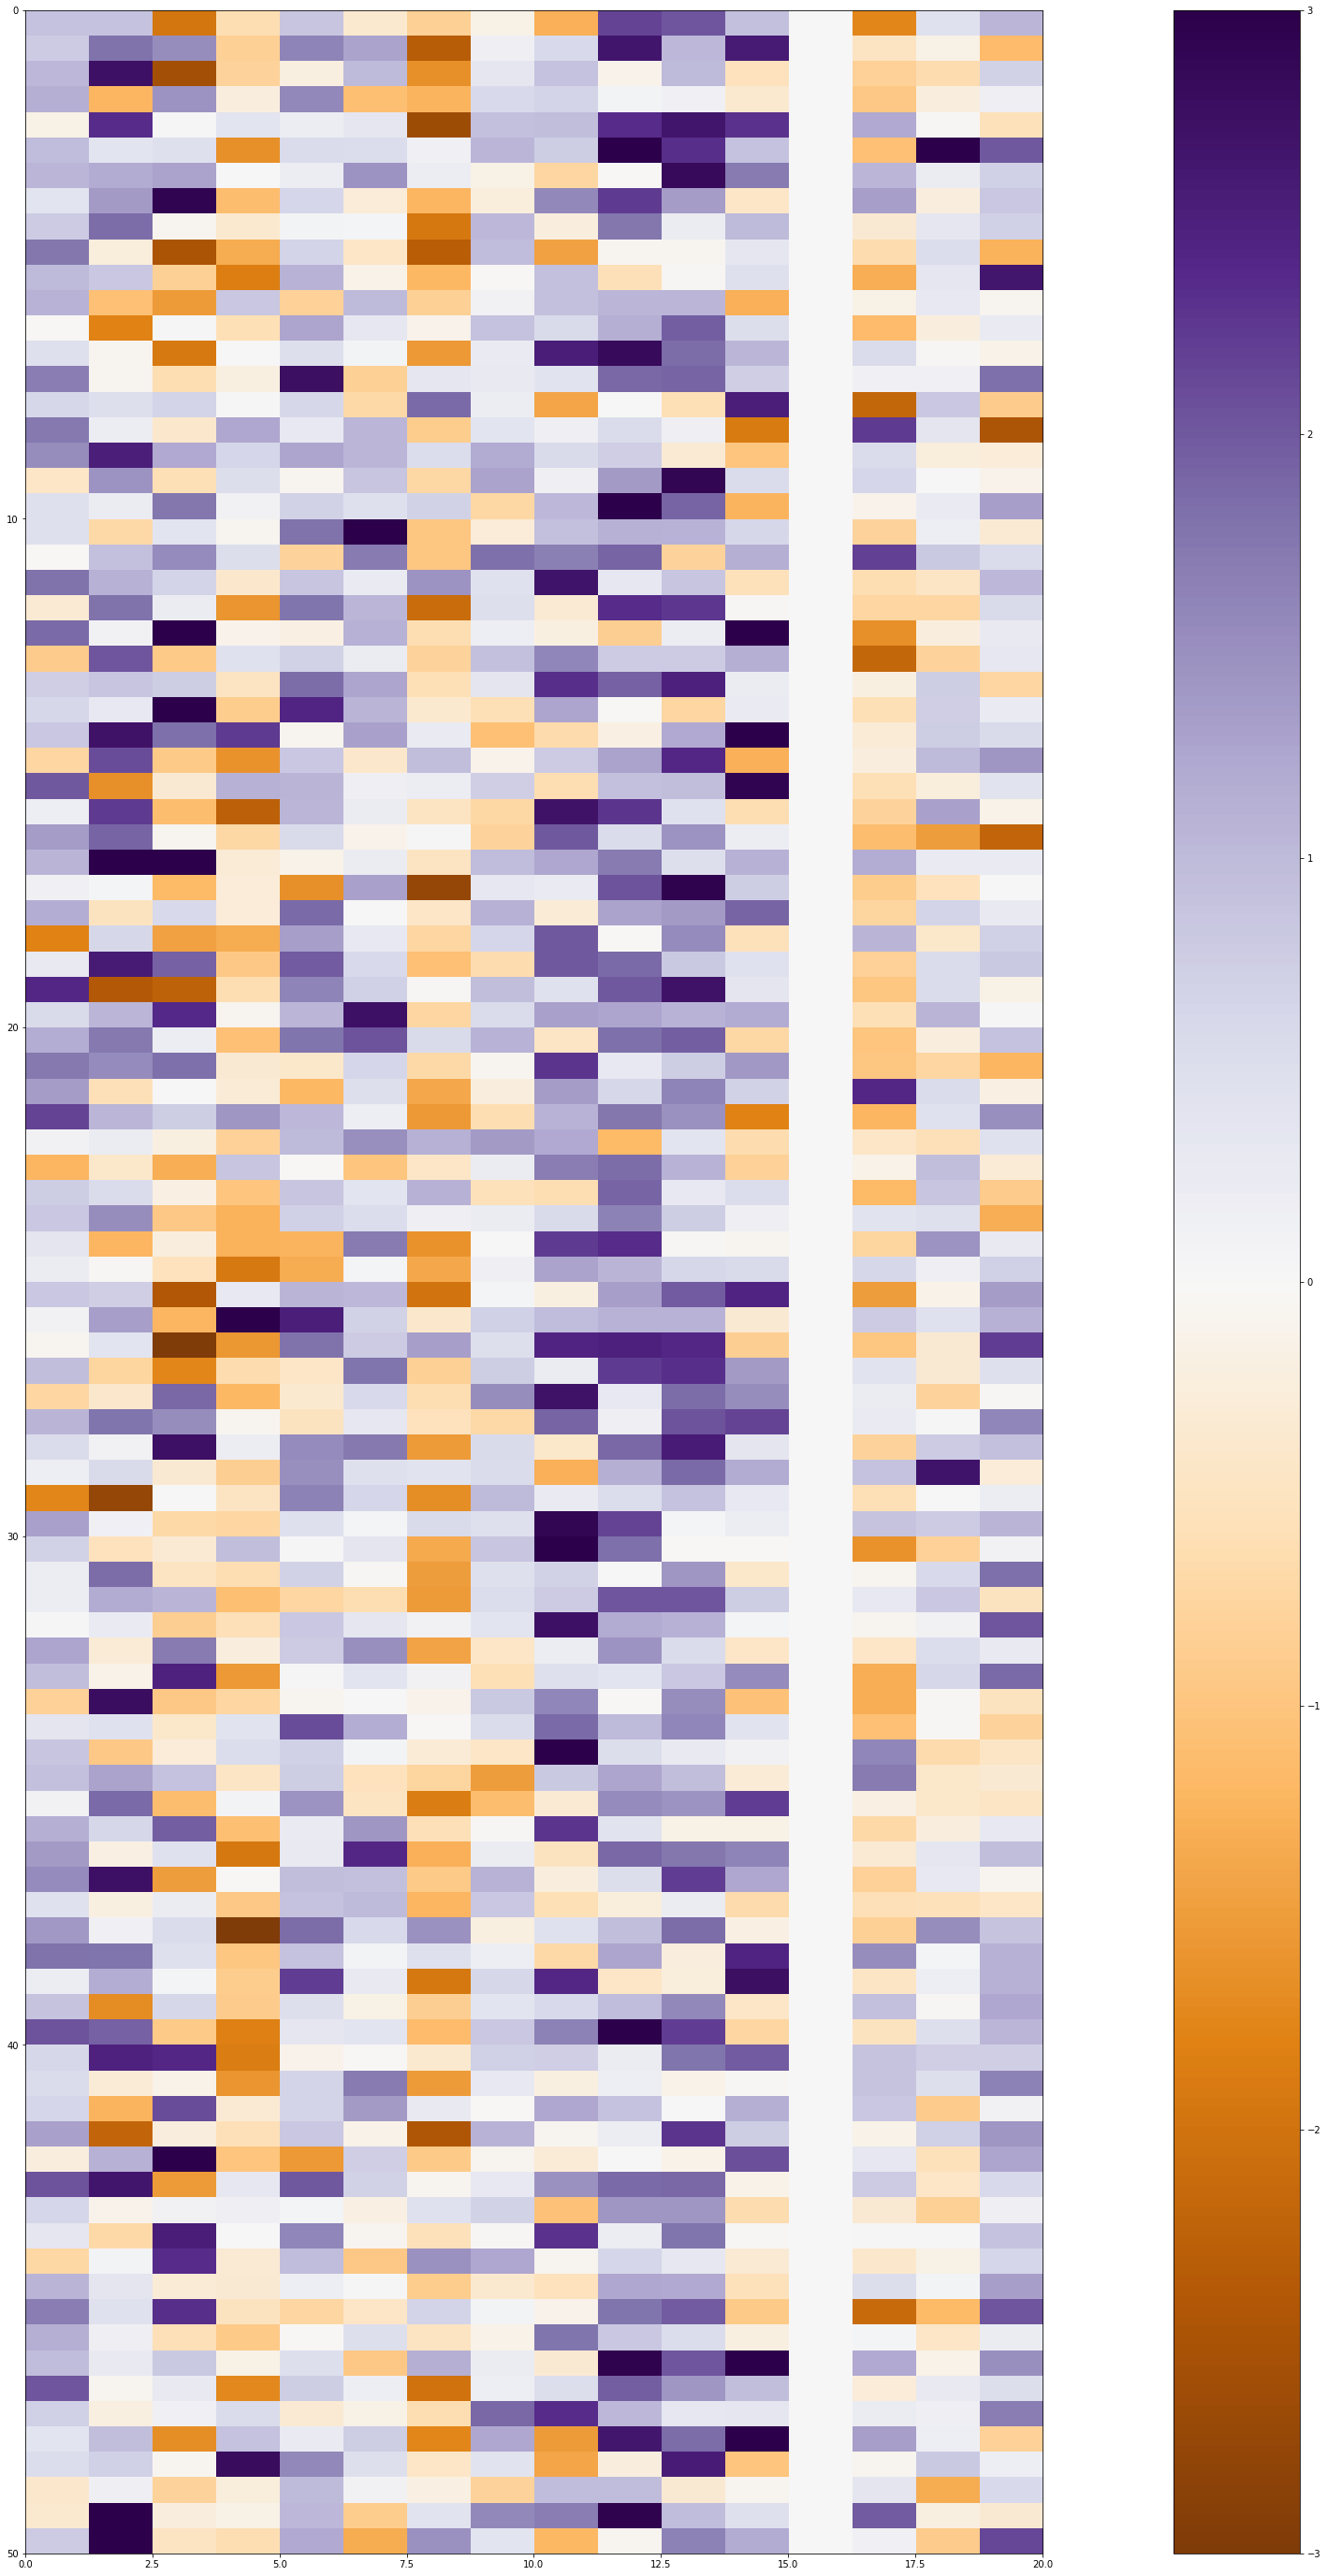

In [126]:
plt.figure(figsize=(50, 50))
plt.imshow(mat[:100], cmap="PuOr", extent=(0, 20, 50, 0), vmin=-3, vmax=3)
plt.colorbar()

In [38]:
s8 = np.load("/home/pbromley/generative_dhs/optimized/nz100/seqs-16.npy")
s8_seqs = [utils.one_hot_to_seq(o) for o in s8]
utils.calc_overall_composition(s8_seqs)

array([ 23.6025,  24.1855,  25.771 ,  26.441 ])

In [12]:
fixed_z = np.load("/home/pbromley/generative_dhs/data_numpy/fixed_zs_100.npy")

In [13]:
fixed_z[:10000]

array([[-1.37138946, -0.36056112,  2.38058177, ...,  0.23343317,
         1.12943796,  0.93363154],
       [-2.02390197,  0.17178443,  1.33482859, ...,  0.5009397 ,
        -1.04198057, -0.75792457],
       [ 0.96388351,  0.5824707 , -0.66882246, ..., -1.01053753,
        -0.82684686, -0.23076542],
       ..., 
       [-1.09988085,  0.93107156,  0.31719025, ...,  0.83963312,
         1.85473275, -0.28340506],
       [-0.31713081, -0.40464927, -0.60572269, ...,  1.79659072,
        -0.9357264 , -0.53408843],
       [-0.11475137,  0.58471856, -0.91215166, ..., -0.27558238,
        -1.17434583,  0.19441012]])

In [14]:
optimized_z = np.load("/home/pbromley/generative_dhs/optimized/nz100/zs-1.npy")

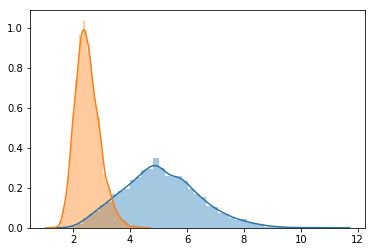

In [16]:
sns.distplot(optimized_z.max(1))
sns.distplot(fixed_z[:10000].max(1))

In [17]:
optimized_z.max(1)

array([ 9.14926815,  3.29899526,  4.4548707 , ...,  4.47158957,
        6.3837533 ,  7.21756601], dtype=float32)

In [18]:
fixed_z.max(1)

array([ 2.83205689,  2.18175175,  2.16727143, ...,  2.46065693,
        2.55002655,  1.74124668])

In [85]:
for i in range(16):
    si = np.load("/home/pbromley/generative_dhs/optimized/nz100/seqs-{0}.npy".format(i+1))
    seqsi = [utils.one_hot_to_seq(s) for s in si]
    print(utils.count_cpg_sites(seqsi))

9.8928
1.7638
1.6005
0.731
1.83
1.418
2.622
3.5495
1.63
5.3265
1.084
1.983
1.5844
2.7644
1.8525
1.238


(array([  1.80811321e-01,   2.49754717e-01,   2.00396226e-01,
          1.28622642e-01,   7.53584906e-02,   4.13207547e-02,
          2.50188679e-02,   1.85660377e-02,   1.42264151e-02,
          1.28113208e-02,   1.24528302e-02,   1.00000000e-02,
          8.41509434e-03,   6.07547170e-03,   5.09433962e-03,
          4.09433962e-03,   2.62264151e-03,   1.66037736e-03,
          1.00000000e-03,   6.22641509e-04,   3.96226415e-04,
          1.69811321e-04,   1.32075472e-04,   1.88679245e-04,
          3.77358491e-05,   1.50943396e-04]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.]),
 <a list of 26 Patch objects>)

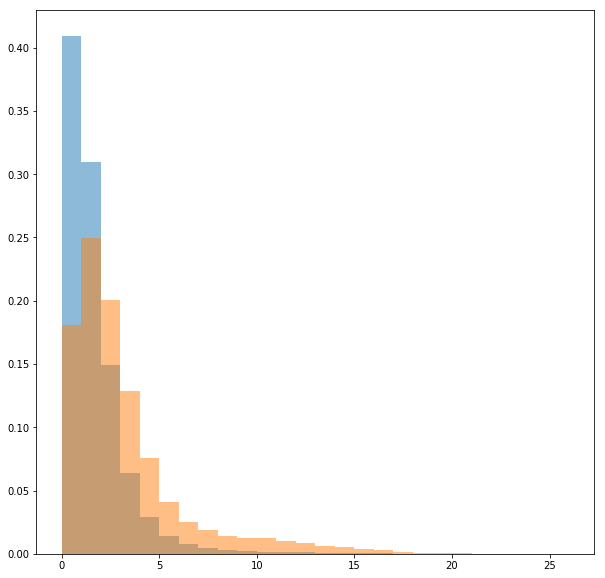

In [107]:
cpg = []
cpg1 = []
for i in range(len(real_seqs)):
    cpg.append(utils.count_cpg_sites([real_seqs[i]]))
for i in range(16):
    si = np.load("/home/pbromley/generative_dhs/optimized/nz100/seqs-{0}.npy".format(i+1))
    seqsi = [utils.one_hot_to_seq(s) for s in si]
    for j in range(len(seqsi)):
        cpg1.append(utils.count_cpg_sites([seqsi[j]]))
plt.figure(figsize=(10, 10))
plt.hist(cpg, bins=24, density=True, alpha=0.5)
plt.hist(cpg1, bins=26, density=True, alpha=0.5)

In [123]:
seq_array = []
for i in range(16):
    si = np.load("/home/pbromley/generative_dhs/optimized/nz100/seqs-{0}.npy".format(i+1))
    seqsi = [utils.one_hot_to_seq(s) for s in si]
    for j in range(2000):
        seq_array.append(SeqRecord(seqsi[j], id=str(i+1)))
SeqIO.write(seq_array, "/home/pbromley/generative_dhs/memes/new_memes/opt_seqs.fasta", "fasta")

32000

In [127]:
seq_array = []
for i in range(256000):
    seq_array.append(SeqRecord(real_seqs[i], id=str(components[i]+1)))
SeqIO.write(seq_array, "/home/pbromley/generative_dhs/memes/new_memes/real_seqs.fasta", "fasta")

256000

In [111]:
all_seqs = []
for i in range(16):
    si = np.load("/home/pbromley/generative_dhs/optimized/nz100/seqs-{0}.npy".format(i+1))[:2000]
    seqsi = [utils.one_hot_to_seq(s) for s in si]
    for seq in seqsi:
        all_seqs.append(seq)

In [113]:
utils.calc_overall_composition(all_seqs)

array([ 21.39453125,  22.6316875 ,  27.2025625 ,  28.77121875])

In [114]:
22.27459766 + 22.31487109

44.58946875

In [116]:
s5 = np.load("/home/pbromley/generative_dhs/optimized/nz100/seqs-5.npy")

In [117]:
utils.calc_overall_composition([utils.one_hot_to_seq(o) for o in s5])

array([ 22.6782,  23.4766,  26.2348,  27.6104])

In [67]:
z1 = np.random.normal(0, 1, 50)
z2 = np.random.normal(0, 1, 50)
x1 = utils.one_hot_to_seq(G(torch.FloatTensor(z1).cuda()).detach().cpu().numpy().squeeze())
x2 = utils.one_hot_to_seq(G(torch.FloatTensor(z2).cuda()).detach().cpu().numpy().squeeze())

In [68]:
def calc_changed_nucleotides(s1, s2):
    d = 0
    for i in range(100):
        if s1[i] != s2[i]:
            d += 1
    return d

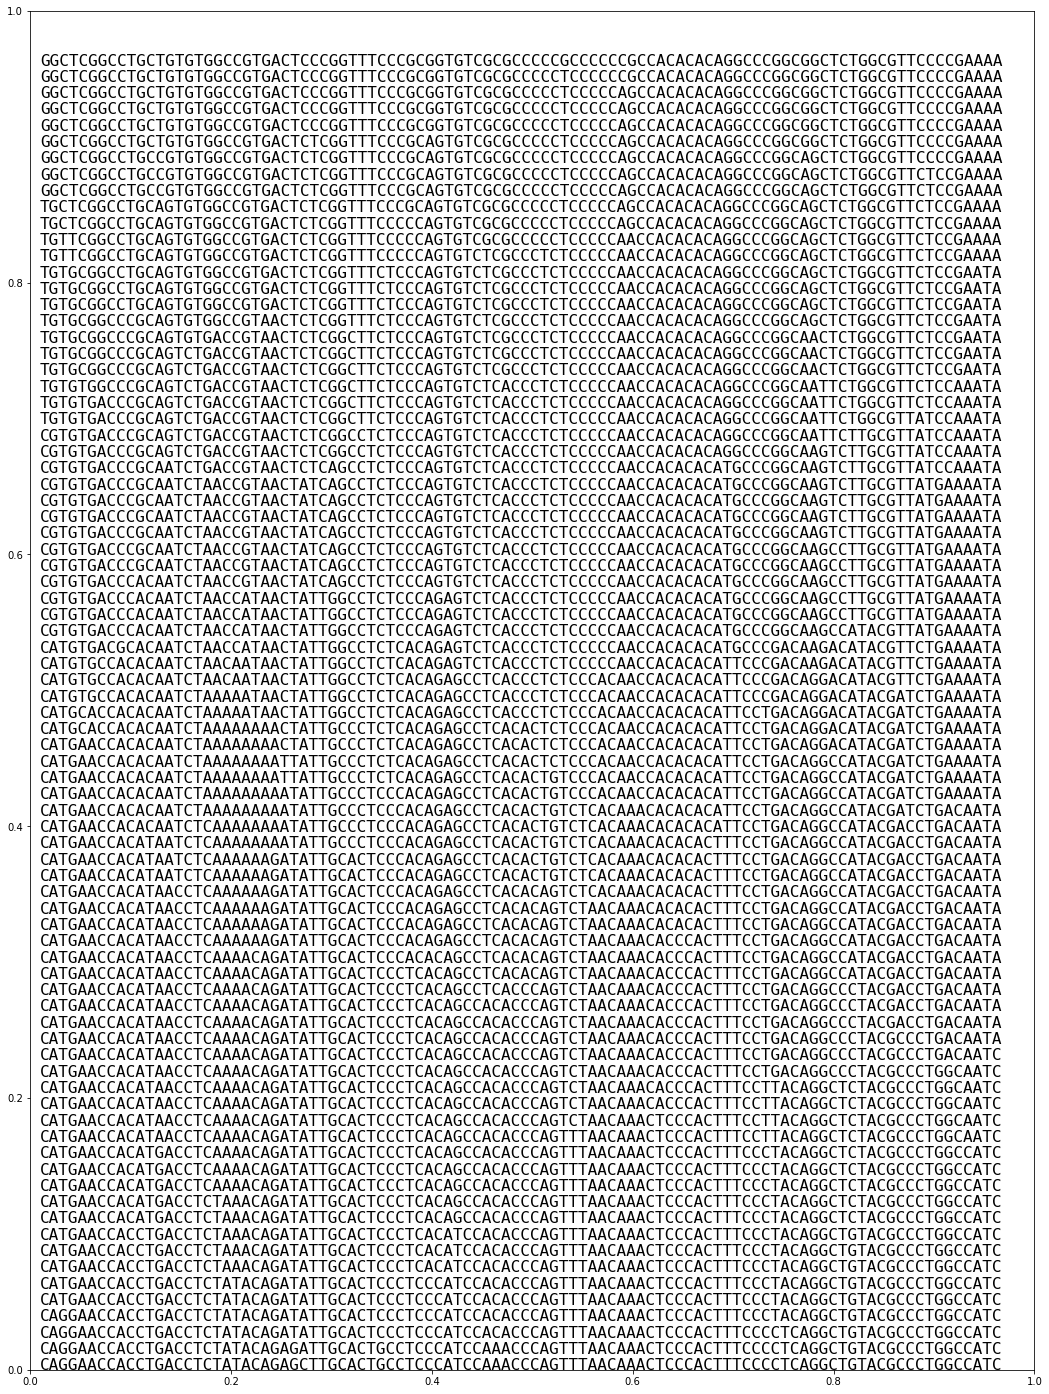

In [69]:
from matplotlib.font_manager import FontProperties
font = FontProperties()
font.set_family('monospace')
font.set_size(16)
plt.figure(figsize=(18, 25))
# plt.text(0.01, 0.1, utils.one_hot_to_seq(x1.detach().cpu().numpy().reshape(100, 4)), fontsize=14)
dz = z2 - z1
before = x1
ds = []
for i in range(81):
    z = z1 + (0.0125 * i * dz)
    x = G(torch.FloatTensor(z).cuda()).detach().cpu().numpy().squeeze()
    xseq = utils.one_hot_to_seq(x)
    ds.append(calc_changed_nucleotides(before, xseq))
    before = xseq
    plt.text(0.01, i*0.012, xseq, fontproperties=font)

73


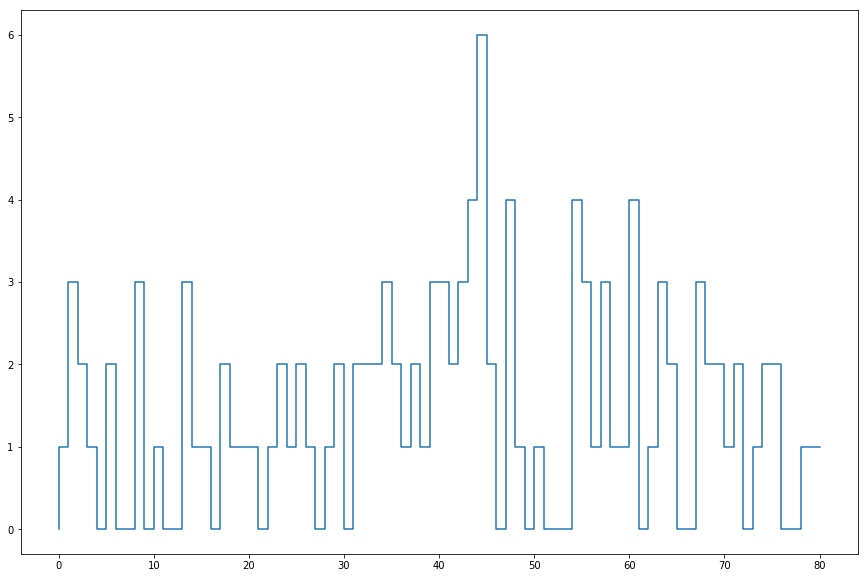

In [70]:
plt.figure(figsize=(15, 10))
print(calc_changed_nucleotides(x1, x2))
plt.step(np.arange(81), ds)